In [13]:
import pandas as pd
import numpy as np

def read_hk_monthly_csv(path: str) -> pd.DataFrame:
    raw = pd.read_csv(path, header=None, dtype=str)

    # 找到第一個像 Jan-99 的日期行
    mask = raw.iloc[:, 0].astype(str).str.match(r"^[A-Za-z]{3}-\d{2}$", na=False)
    if not mask.any():
        raise ValueError("搵唔到 Jan-99 呢種日期行，請確認第一欄係月份。")

    first_data_row = mask.idxmax()
    header_row = first_data_row - 1

    df = pd.read_csv(path, header=header_row)
    df.columns = df.columns.astype(str).str.strip()

    # 日期欄 = 第一欄
    date_col = df.columns[0]
    df['date'] = pd.to_datetime(df[date_col], format='%b-%y')
    df = df.drop(columns=[date_col]).set_index('date').sort_index()

    # 數字化（Remarks / Z / 空白 -> NaN）
    df = df.apply(pd.to_numeric, errors='coerce')
    return df

rent = read_hk_monthly_csv("rent.csv")
price = read_hk_monthly_csv("price.csv")



In [14]:
print("rent date range:", rent.index.min(), "->", rent.index.max())
print("price date range:", price.index.min(), "->", price.index.max())


rent date range: 1999-01-01 00:00:00 -> 2025-11-01 00:00:00
price date range: 1999-01-01 00:00:00 -> 2025-11-01 00:00:00


In [15]:
print(rent.columns[:15])


Index(['Class A Hong Kong', 'Class A Hong Kong - Remarks', 'Class A Kowloon',
       'Class A Kowloon - Remarks', 'Class A New Territories',
       'Class A New Territories - Remarks', 'Class B Hong Kong',
       'Class B Hong Kong - Remarks', 'Class B Kowloon',
       'Class B Kowloon - Remarks', 'Class B New Territories',
       'Class B New Territories - Remarks', 'Class C Hong Kong',
       'Class C Hong Kong - Remarks', 'Class C Kowloon'],
      dtype='object')


In [16]:
rent.head(2)


,Class A Hong Kong,Class A Hong Kong - Remarks,Class A Kowloon,Class A Kowloon - Remarks,Class A New Territories,Class A New Territories - Remarks,Class B Hong Kong,Class B Hong Kong - Remarks,Class B Kowloon,Class B Kowloon - Remarks,...,Class D Kowloon,Class D Kowloon - Remarks,Class D New Territories,Class D New Territories - Remarks,Class E Hong Kong,Class E Hong Kong - Remarks,Class E Kowloon,Class E Kowloon - Remarks,Class E New Territories,Class E New Territories - Remarks
date,,,,,,,,,,,,,,,,,,,,,
1999-01-01,190,NaN,171,NaN,133,NaN,199,NaN,165,NaN,...,198,NaN,185,NaN,301,NaN,185.0,NaN,191.0,NaN
1999-02-01,196,NaN,173,NaN,133,NaN,204,NaN,165,NaN,...,196,NaN,173,NaN,311,NaN,213.0,NaN,152.0,NaN


In [17]:

a_cols = [c for c in price.columns
          if str(c).startswith("Class A ") and "Remarks" not in str(c)]
a_cols


['Class A Hong Kong', 'Class A Kowloon', 'Class A New Territories']

In [2]:
yield_A = (rent[a_cols] * 12 / price[a_cols]) * 100
yield_A = yield_A.rename(columns=lambda x: x.replace("Class A ", ""))
yield_A.head()


NameError: name 'rent' is not defined

In [1]:
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

plot_A = yield_A.reset_index().melt(
    id_vars="date",
    var_name="Area",
    value_name="Yield"
)

plt.figure(figsize=(11,5))
sns.lineplot(data=plot_A, x="date", y="Yield", hue="Area")

plt.title("Hong Kong Rental Yield – Class A (1999 JAN –2025 NOV)")
plt.ylabel("Rental Yield (%)")
plt.xlabel("")
plt.legend(title="Area")
plt.tight_layout()
plt.show()


NameError: name 'yield_A' is not defined

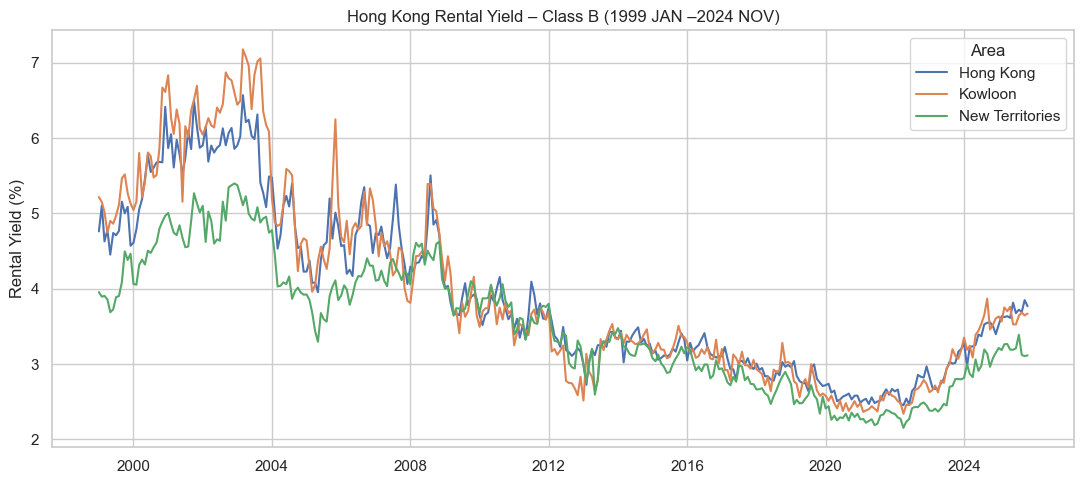

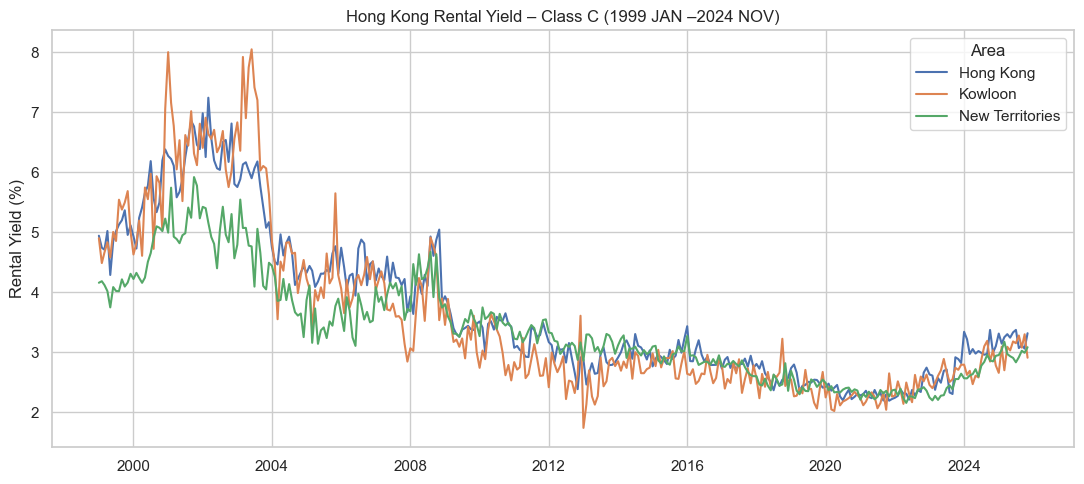

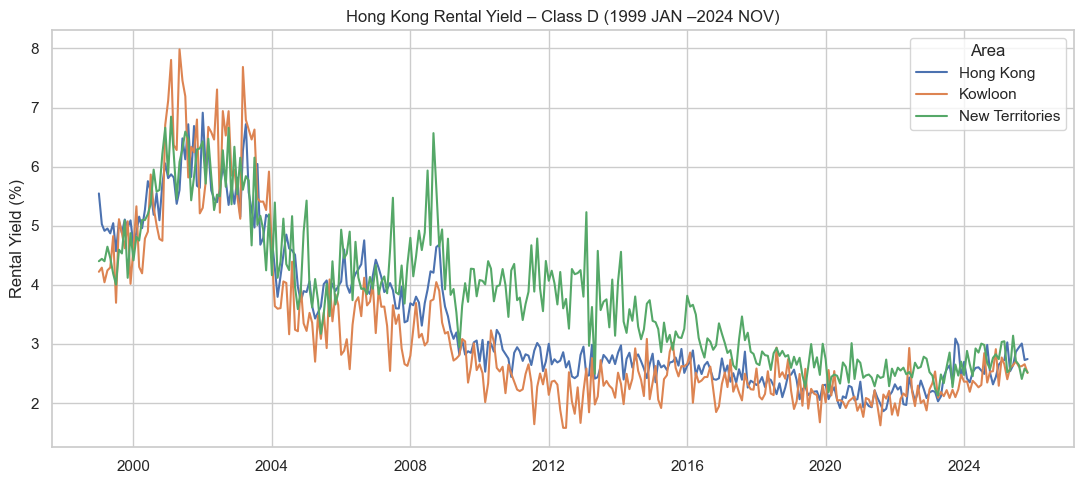

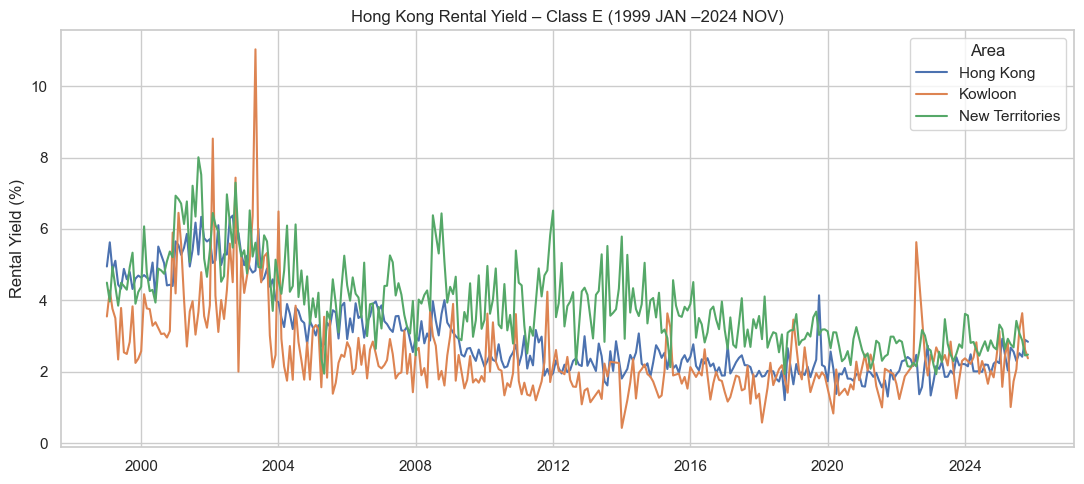

In [22]:

sns.set_theme(style="whitegrid")

def plot_yield_for_class(cls: str):
    # grab 3 area cols for that class, ignore remarks
    cols = [c for c in price.columns
            if str(c).startswith(f"Class {cls} ") and "Remarks" not in str(c)]
    if len(cols) == 0:
        raise ValueError(f"No columns found for Class {cls}. Check your column names.")

    # compute yield (%)
    y = (rent[cols] * 12 / price[cols]) * 100
    y = y.rename(columns=lambda x: str(x).replace(f"Class {cls} ", ""))

    # long format for seaborn
    plot_df = y.reset_index().melt(id_vars="date", var_name="Area", value_name="Yield")

    plt.figure(figsize=(11,5))
    sns.lineplot(data=plot_df, x="date", y="Yield", hue="Area")
    plt.title(f"Hong Kong Rental Yield – Class {cls} (1999 JAN –2024 NOV)")
    plt.ylabel("Rental Yield (%)")
    plt.xlabel("")
    plt.legend(title="Area")
    plt.tight_layout()
    plt.show()

for cls in ["B", "C", "D", "E"]:
    plot_yield_for_class(cls)


In [49]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

sns.set_theme(style="whitegrid")

def plot_yield_by_area(area: str):
    # 1) columns for this area (ignore remarks)
    cols = [c for c in price.columns if str(c).endswith(area) and "Remarks" not in str(c)]
    if not cols:
        raise ValueError(f"No columns found for area='{area}'. Check column names.")

    # 2) compute yield (%)
    y = (rent[cols] * 12 / price[cols]) * 100
    y = y.rename(columns=lambda x: str(x).replace(f" {area}", ""))

    # 3) long format for seaborn
    plot_df = y.reset_index().melt(
        id_vars="date",
        var_name="Class",
        value_name="Yield"
    )

    # 4) plot lines
    plt.figure(figsize=(11, 5))
    ax = sns.lineplot(data=plot_df, x="date", y="Yield", hue="Class")

    # ===== Right-side labels with forced spacing (no overlap) =====
    last_date = plot_df["date"].max()
    x_text = last_date + pd.DateOffset(months=3)

    labels = (
        plot_df[plot_df["date"] == last_date]
        .dropna(subset=["Yield"])
        .sort_values("Yield", ascending=False)
        .reset_index(drop=True)
    )

    y_min, y_max = ax.get_ylim()
    step = (y_max - y_min) * 0.07  # spacing strength (try 0.06~0.10)

    # start from the top label position (cap inside ylim)
    start_y = min(labels["Yield"].max(), y_max - step)

    for i, row in labels.iterrows():
        y_pos = start_y - i * step
        ax.text(
            x_text,
            y_pos,
            f"{row['Yield']:.2f}%",
            fontsize=9,
            va="center",
            ha="left",
            bbox=dict(facecolor="white", edgecolor="none", alpha=0.85)  # clearer
        )

    # extend x-axis so labels are visible
    ax.set_xlim(plot_df["date"].min(), x_text)

    # 5) titles etc.
    plt.title(f"Rental Yield by Class – {area} (1999–2024)")
    plt.ylabel("Rental Yield (%)")
    plt.xlabel("")
    plt.legend(title="Class")
    plt.tight_layout()
    plt.show()


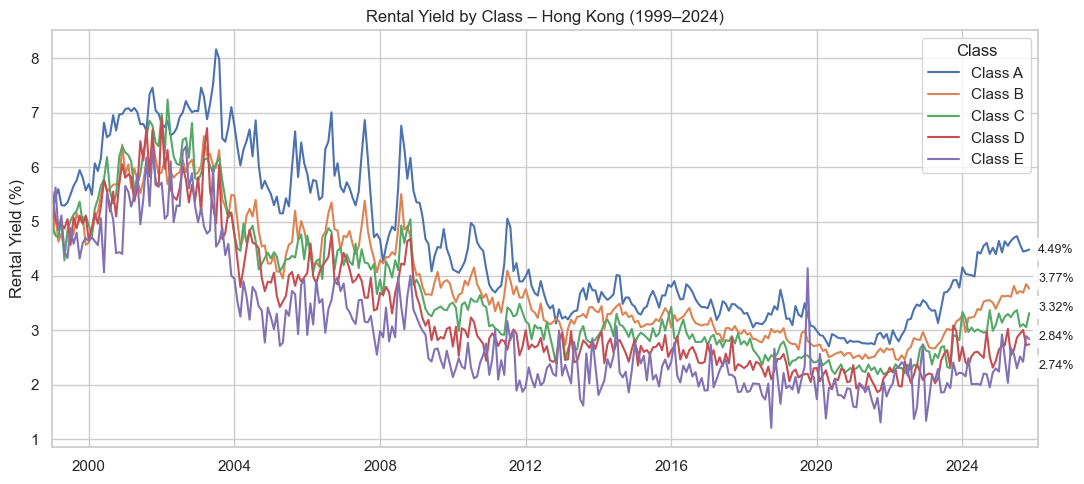

In [50]:
plot_yield_by_area("Hong Kong")

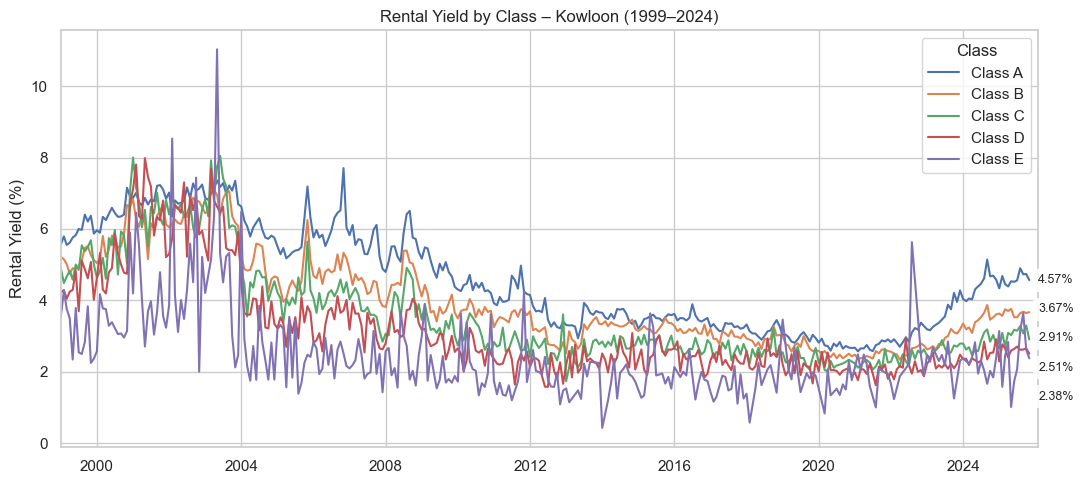

In [51]:
plot_yield_by_area("Kowloon")

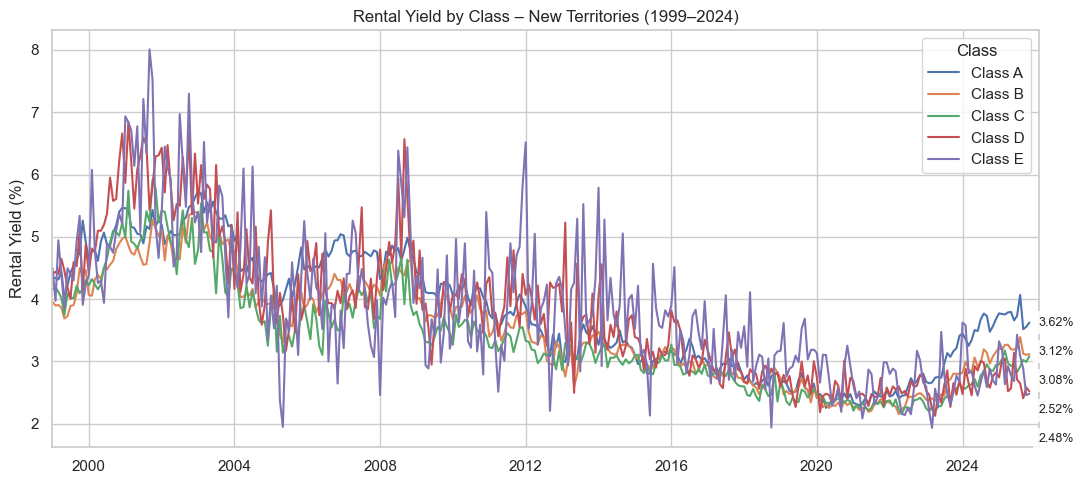

In [52]:
plot_yield_by_area("New Territories")